In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
awhitu = pd.read_csv('../../Data/soil data/AcrossAucklandRainfallStation/awhituCombined_Data_15mins.csv', parse_dates=['Timestamp (UTC+12:00)'])
awhitu.head()

,Timestamp (UTC+12:00),Rain(mm),SoilTemp(c),SoilMoisture(%),Column1,Column2
0,2014-05-27 17:45:00,0.0,14.2,43.589,NaN,NaN
1,2014-05-27 18:00:00,0.0,14.2,43.587,NaN,NaN
2,2014-05-27 18:15:00,0.0,14.0,43.586,NaN,NaN
3,2014-05-27 18:30:00,0.0,14.0,43.561,NaN,NaN
4,2014-05-27 18:45:00,0.0,13.9,43.561,NaN,NaN


Resample Data to 15 minutes interval

In [4]:
awhitu.set_index('Timestamp (UTC+12:00)', inplace=True)

resampled_df = awhitu.resample('H').agg({
    'Rain(mm)': 'sum',
    'SoilTemp(c)': 'mean',
    'SoilMoisture(%)': 'mean'
})

C:\Users\Ying\AppData\Local\Temp\ipykernel_8428\3654246398.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_df = awhitu.resample('H').agg({


Cross-correlation

In [5]:
import numpy as np
from scipy.signal import correlate
import matplotlib.pyplot as plt

max_lag = 30

def cross_correlation(x, y, max_lag):
    """Calculate cross-correlation between two signals."""
    correlation = correlate(x, y, mode='full')
    lags = np.arange(-len(x) + 1, len(y))
    return lags, correlation

In [6]:
awhitu_daily = awhitu.resample('D').agg({'Rain(mm)': 'sum','SoilTemp(c)': 'mean','SoilMoisture(%)': 'mean'})

In [7]:
soil_moisture = awhitu_daily['SoilMoisture(%)'].values
rainfall = awhitu_daily['Rain(mm)'].values
soil_temp = awhitu_daily['SoilTemp(c)'].values

In [8]:
awhitu_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3760 entries, 2014-05-27 to 2024-09-10
Freq: D
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Rain(mm)         3760 non-null   float64
 1   SoilTemp(c)      2857 non-null   float64
 2   SoilMoisture(%)  2857 non-null   float64
dtypes: float64(3)
memory usage: 117.5 KB


In [9]:
# Calculate 7-day rolling average for Rain(mm), SoilTemp(c), and SoilMoisture(%)
awhitu_daily['Rain_7d_avg'] = awhitu_daily['Rain(mm)'].rolling(window=7, min_periods=1).sum()
awhitu_daily['SoilTemp_7d_avg'] = awhitu_daily['SoilTemp(c)'].rolling(window=7, min_periods=1).mean()

# Calculate 30-day rolling average for the same columns
awhitu_daily['Rain_30d_avg'] = awhitu_daily['Rain(mm)'].rolling(window=30, min_periods=1).sum()
awhitu_daily['SoilTemp_30d_avg'] = awhitu_daily['SoilTemp(c)'].rolling(window=30, min_periods=1).mean()
# awhitu_daily['SoilMoisture_30d_avg'] = awhitu_daily['SoilMoisture(%)'].rolling(window=30, min_periods=1).mean()
awhitu_daily.head()


,Rain(mm),SoilTemp(c),SoilMoisture(%),Rain_7d_avg,SoilTemp_7d_avg,Rain_30d_avg,SoilTemp_30d_avg
Timestamp (UTC+12:00),,,,,,,
2014-05-27,0.0,13.400000,43.587800,0.0,13.400000,0.0,13.400000
2014-05-28,0.0,11.947917,43.631698,0.0,12.673958,0.0,12.673958
2014-05-29,0.0,12.942708,43.738906,0.0,12.763542,0.0,12.763542
2014-05-30,1.5,15.031250,43.836781,1.5,13.330469,1.5,13.330469
2014-05-31,0.0,14.598958,43.866385,1.5,13.584167,1.5,13.584167


In [10]:
rainfall_lags = [1, 3, 5, 7]  
soil_temp_lags = [1, 3, 7, 14, 28] 

for i in rainfall_lags:
    awhitu_daily[f'Rainfall_lag_{i}'] = awhitu_daily['Rain(mm)'].shift(i)

for i in soil_temp_lags:
    awhitu_daily[f'SoilTemp_lag_{i}'] = awhitu_daily['SoilTemp(c)'].shift(i)

# Drop rows with NaN values in the lag features
awhitu_daily.dropna(inplace=True)

In [11]:
lag_size = 30
# Calculate cross-correlation for rainfall and soil temperature
lags_rain_temp, correlation_rain_temp = cross_correlation(rainfall, soil_temp, lag_size)
print("Cross-Correlation between Rainfall and Soil Temperature:")
print("Lags:", lags_rain_temp)
print("Correlation:", correlation_rain_temp)

Cross-Correlation between Rainfall and Soil Temperature:
Lags: [-3759 -3758 -3757 ...  3757  3758  3759]
Correlation: [nan nan nan ... nan nan nan]


c:\Users\Ying\.conda\envs\level8\lib\site-packages\scipy\signal\_signaltools.py:243: RuntimeWarning: Use of fft convolution on input with NAN or inf results in NAN or inf output. Consider using method='direct' instead.
  return convolve(in1, _reverse_and_conj(in2), mode, method)


In [12]:

# Calculate cross-correlation for rainfall and soil moisture
lags_rain_moist, correlation_rain_moist = cross_correlation(rainfall, soil_moisture, lag_size)
print("\nCross-Correlation between Rainfall and Soil Moisture:")
print("Lags:", lags_rain_moist)
print("Correlation:", correlation_rain_moist)


Cross-Correlation between Rainfall and Soil Moisture:
Lags: [-3759 -3758 -3757 ...  3757  3758  3759]
Correlation: [nan nan nan ... nan nan nan]


In [13]:
# Calculate cross-correlation for soil moisture and soil temperature
lags_moist_temp, correlation_moist_temp = cross_correlation(soil_moisture, soil_temp, lag_size)
print("\nCross-Correlation between Soil Moisture and Soil Temperature:")
print("Lags:", lags_moist_temp)
print("Correlation:", correlation_moist_temp)


Cross-Correlation between Soil Moisture and Soil Temperature:
Lags: [-3759 -3758 -3757 ...  3757  3758  3759]
Correlation: [nan nan nan ... nan nan nan]


<Axes: >

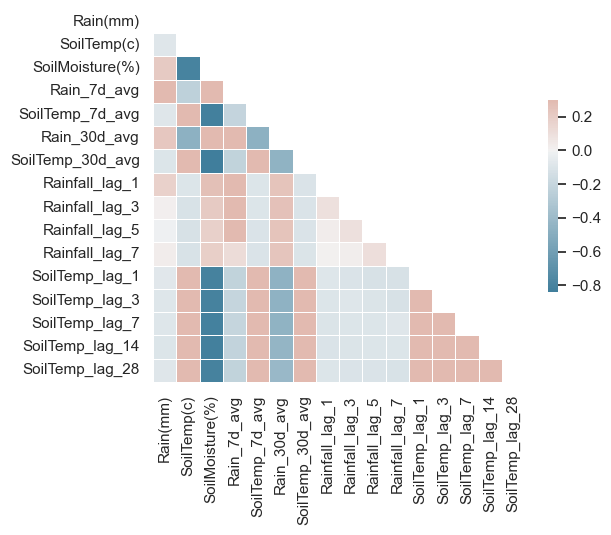

In [14]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")


# Compute the correlation matrix
corr = awhitu_daily.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(6, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Predictive Model

In [15]:
awhitu_daily.columns

Index(['Rain(mm)', 'SoilTemp(c)', 'SoilMoisture(%)', 'Rain_7d_avg',
       'SoilTemp_7d_avg', 'Rain_30d_avg', 'SoilTemp_30d_avg', 'Rainfall_lag_1',
       'Rainfall_lag_3', 'Rainfall_lag_5', 'Rainfall_lag_7', 'SoilTemp_lag_1',
       'SoilTemp_lag_3', 'SoilTemp_lag_7', 'SoilTemp_lag_14',
       'SoilTemp_lag_28'],
      dtype='object')

In [16]:

X = awhitu_daily.drop(columns=['SoilMoisture(%)'])

y = awhitu_daily[['SoilMoisture(%)']]

X.dropna(inplace=True)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (2721, 15)
y shape: (2721, 1)


In [17]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Random Forest model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

c:\Users\Ying\.conda\envs\level8\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

def evaluate_model(predictions, y_test):
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = sqrt(mse)
    r2 = r2_score(y_test, predictions)

    return mae, mse, rmse, r2

rf_mae, rf_mse, rf_rmse, rf_r2 = evaluate_model(rf_predictions, y_test)

print("\nAwhitu_daily Random Forest Testing Set Metrics:")
print(f"MAE: {rf_mae}")
print(f"MSE: {rf_mse}")
print(f"RMSE: {rf_rmse}")
print(f"R2 Score: {rf_r2}")


Awhitu_daily Random Forest Testing Set Metrics:
MAE: 0.500138078119541
MSE: 0.45619920804232755
RMSE: 0.6754252053649816
R2 Score: 0.9367665944513602


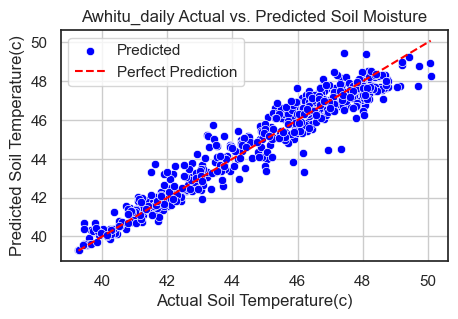

In [20]:
y_test_df = pd.DataFrame(y_test.reset_index(drop=True), columns=['SoilMoisture(%)'])
predictions_df = pd.DataFrame(rf_predictions, columns=['Predicted'])

results_df = pd.concat([y_test_df, predictions_df], axis=1)

plt.figure(figsize=(5, 3))
sns.scatterplot(x=results_df['SoilMoisture(%)'], y=results_df['Predicted'], color='blue', label='Predicted')
plt.plot([results_df['SoilMoisture(%)'].min(), results_df['SoilMoisture(%)'].max()], 
         [results_df['SoilMoisture(%)'].min(), results_df['SoilMoisture(%)'].max()], 
         color='red', linestyle='--', label='Perfect Prediction')
plt.title('Awhitu_daily Actual vs. Predicted Soil Moisture')
plt.xlabel('Actual Soil Temperature(c)')
plt.ylabel('Predicted Soil Temperature(c)')
plt.legend()
plt.grid()
plt.show()

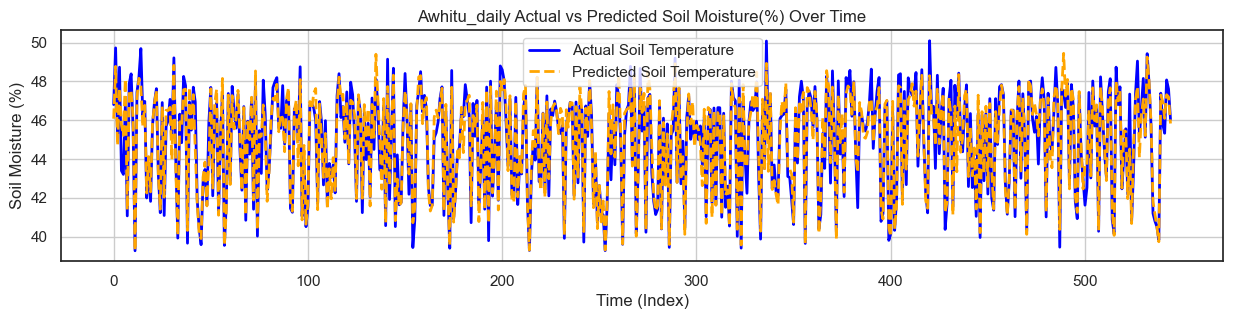

In [21]:
y_test_df = y_test.reset_index(drop=True)
predictions_df = pd.DataFrame(rf_predictions, columns=['Predicted'])
results_df = pd.concat([y_test_df, predictions_df], axis=1)

plt.figure(figsize=(15, 3))
plt.plot(results_df.index, results_df['SoilMoisture(%)'], label='Actual Soil Temperature', color='blue', linewidth=2)
plt.plot(results_df.index, results_df['Predicted'], label='Predicted Soil Temperature', color='orange', linestyle='--', linewidth=2)

# Customize plot labels and legend
plt.title('Awhitu_daily Actual vs Predicted Soil Moisture(%) Over Time')
plt.xlabel('Time (Index)')
plt.ylabel('Soil Moisture (%)')
plt.legend()
plt.grid(True)
plt.show()

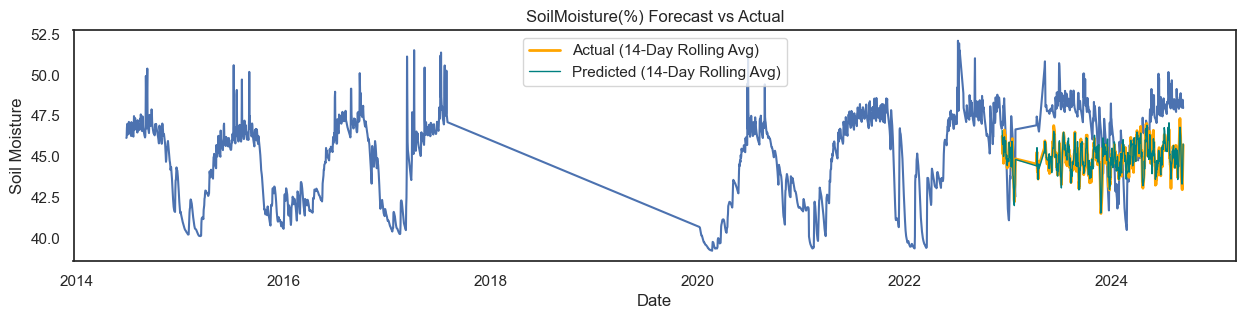

In [22]:
y_test_df = y_test.reset_index(drop=True)
predictions_df = pd.DataFrame(rf_predictions, columns=['Predicted'])
actual_rolling = results_df['SoilMoisture(%)'].rolling(window=7).mean()
predicted_rolling = results_df['Predicted'].rolling(window=7).mean()

results_df = pd.concat([y_test_df, predictions_df], axis=1)
results_df.index = awhitu_daily.index[-len(y_test):] 

plt.figure(figsize=(15, 3))
plt.plot(awhitu_daily['SoilMoisture(%)'])
plt.plot(results_df.index, actual_rolling, color='orange', label='Actual (14-Day Rolling Avg)', linewidth=2)
plt.plot(results_df.index, predicted_rolling, color='teal', label='Predicted (14-Day Rolling Avg)', linewidth=1)

plt.title('SoilMoisture(%) Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Soil Moisture')
plt.legend()
plt.show()



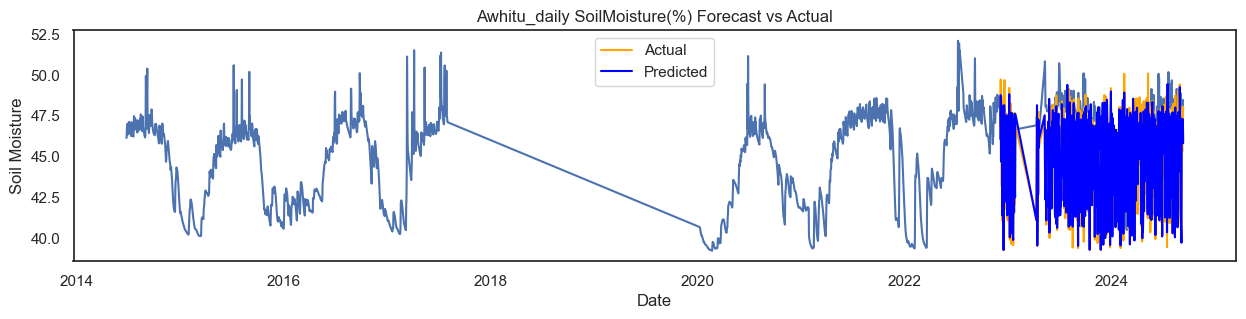

In [23]:
y_test_df = y_test.reset_index(drop=True)
predictions_df = pd.DataFrame(rf_predictions, columns=['Predicted'])

results_df = pd.concat([y_test_df, predictions_df], axis=1)
results_df.index = awhitu_daily.index[-len(y_test):] 

plt.figure(figsize=(15, 3))
plt.plot(awhitu_daily['SoilMoisture(%)'])
plt.plot(results_df.index, results_df['SoilMoisture(%)'], color='orange', label='Actual')
plt.plot(results_df.index, results_df['Predicted'], color='blue', label='Predicted')
plt.title('Awhitu_daily SoilMoisture(%) Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Soil Moisture')
plt.legend()
plt.show()